In [2]:
import numpy
import pandas
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier

In [ ]:
dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}

train = pandas.read_csv("./data/train.csv", parse_dates=["date"], dtype=dtype)
train = train.set_index("date").to_period("D")
train = train.set_index(["store_nbr", "family"], append=True)
avg_sales = train.groupby("date").mean()["sales"]

avg_sales.head()

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911163
2013-01-05    267.873260
Freq: D, Name: sales, dtype: float32

Text(0.5, 1.0, 'Average Sales Over Time')

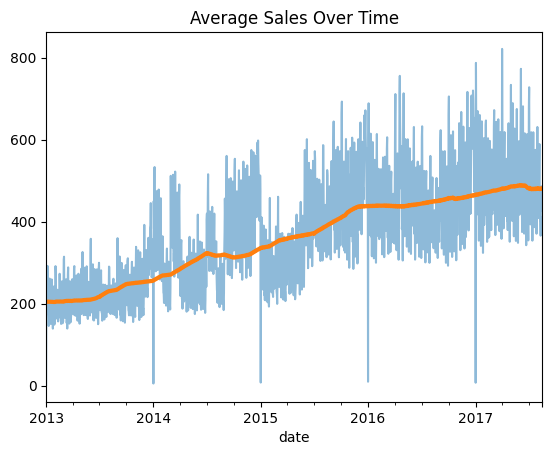

In [4]:
avg_sales_trend = avg_sales.rolling(
    window=365,
    min_periods=183,
    center=True
).mean()

ax = avg_sales.plot(alpha=0.5)
ax = avg_sales_trend.plot(ax=ax, linewidth=3)
ax.set_title("Average Sales Over Time")

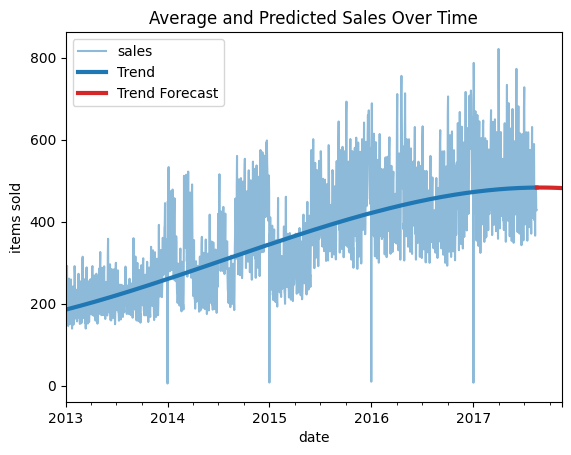

In [17]:
y = avg_sales.copy()
# Selected range to compare one year's worth of data
start, end = "2017-01-01", "2017-12-31"
mask = (y.index >= start) & (y.index <= end)

dp = DeterministicProcess(
    index=y.index,
    order=3,
    drop=True
)

# Use DeterministicProcess to forecast the next 90 days
X = dp.in_sample()
X_forecast = dp.out_of_sample(steps=90)

model = LinearRegression()
model.fit(X, y)

y_pred = pandas.Series(model.predict(X), index=X.index)
y_fore = pandas.Series(model.predict(X_forecast), index=X_forecast.index)

ax = y.plot(alpha=0.5, title="Average and Predicted Sales Over Time", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend()

Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
The seasonal trends in the data likely reflect this fact, therefore, the regression must account for these fluctuations. 

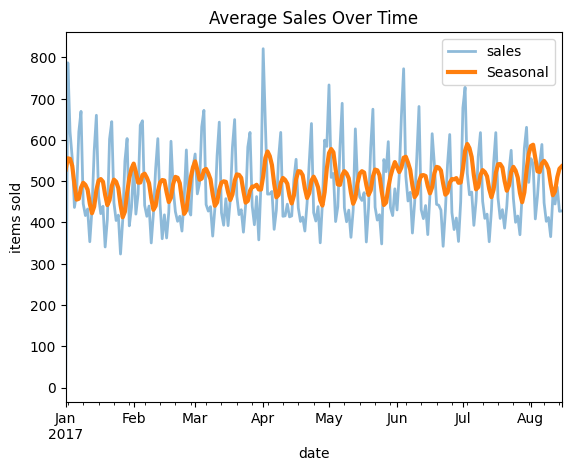

In [18]:
fourier = CalendarFourier("ME", order=4)

dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier]
)

X = dp.in_sample()
model = LinearRegression()
model.fit(X, y)
y_pred = pandas.Series(model.predict(X), index=X.index, name="Fitted")
y_pred = pandas.Series(model.predict(X), index=X.index)

ax = y[mask].plot(alpha=0.5, title="Average Sales Over Time", ylabel="items sold", linewidth=2)
ax = y_pred[mask].plot(ax=ax, label="Seasonal", linewidth=3)
ax.legend()